In [1]:
from PIL import Image

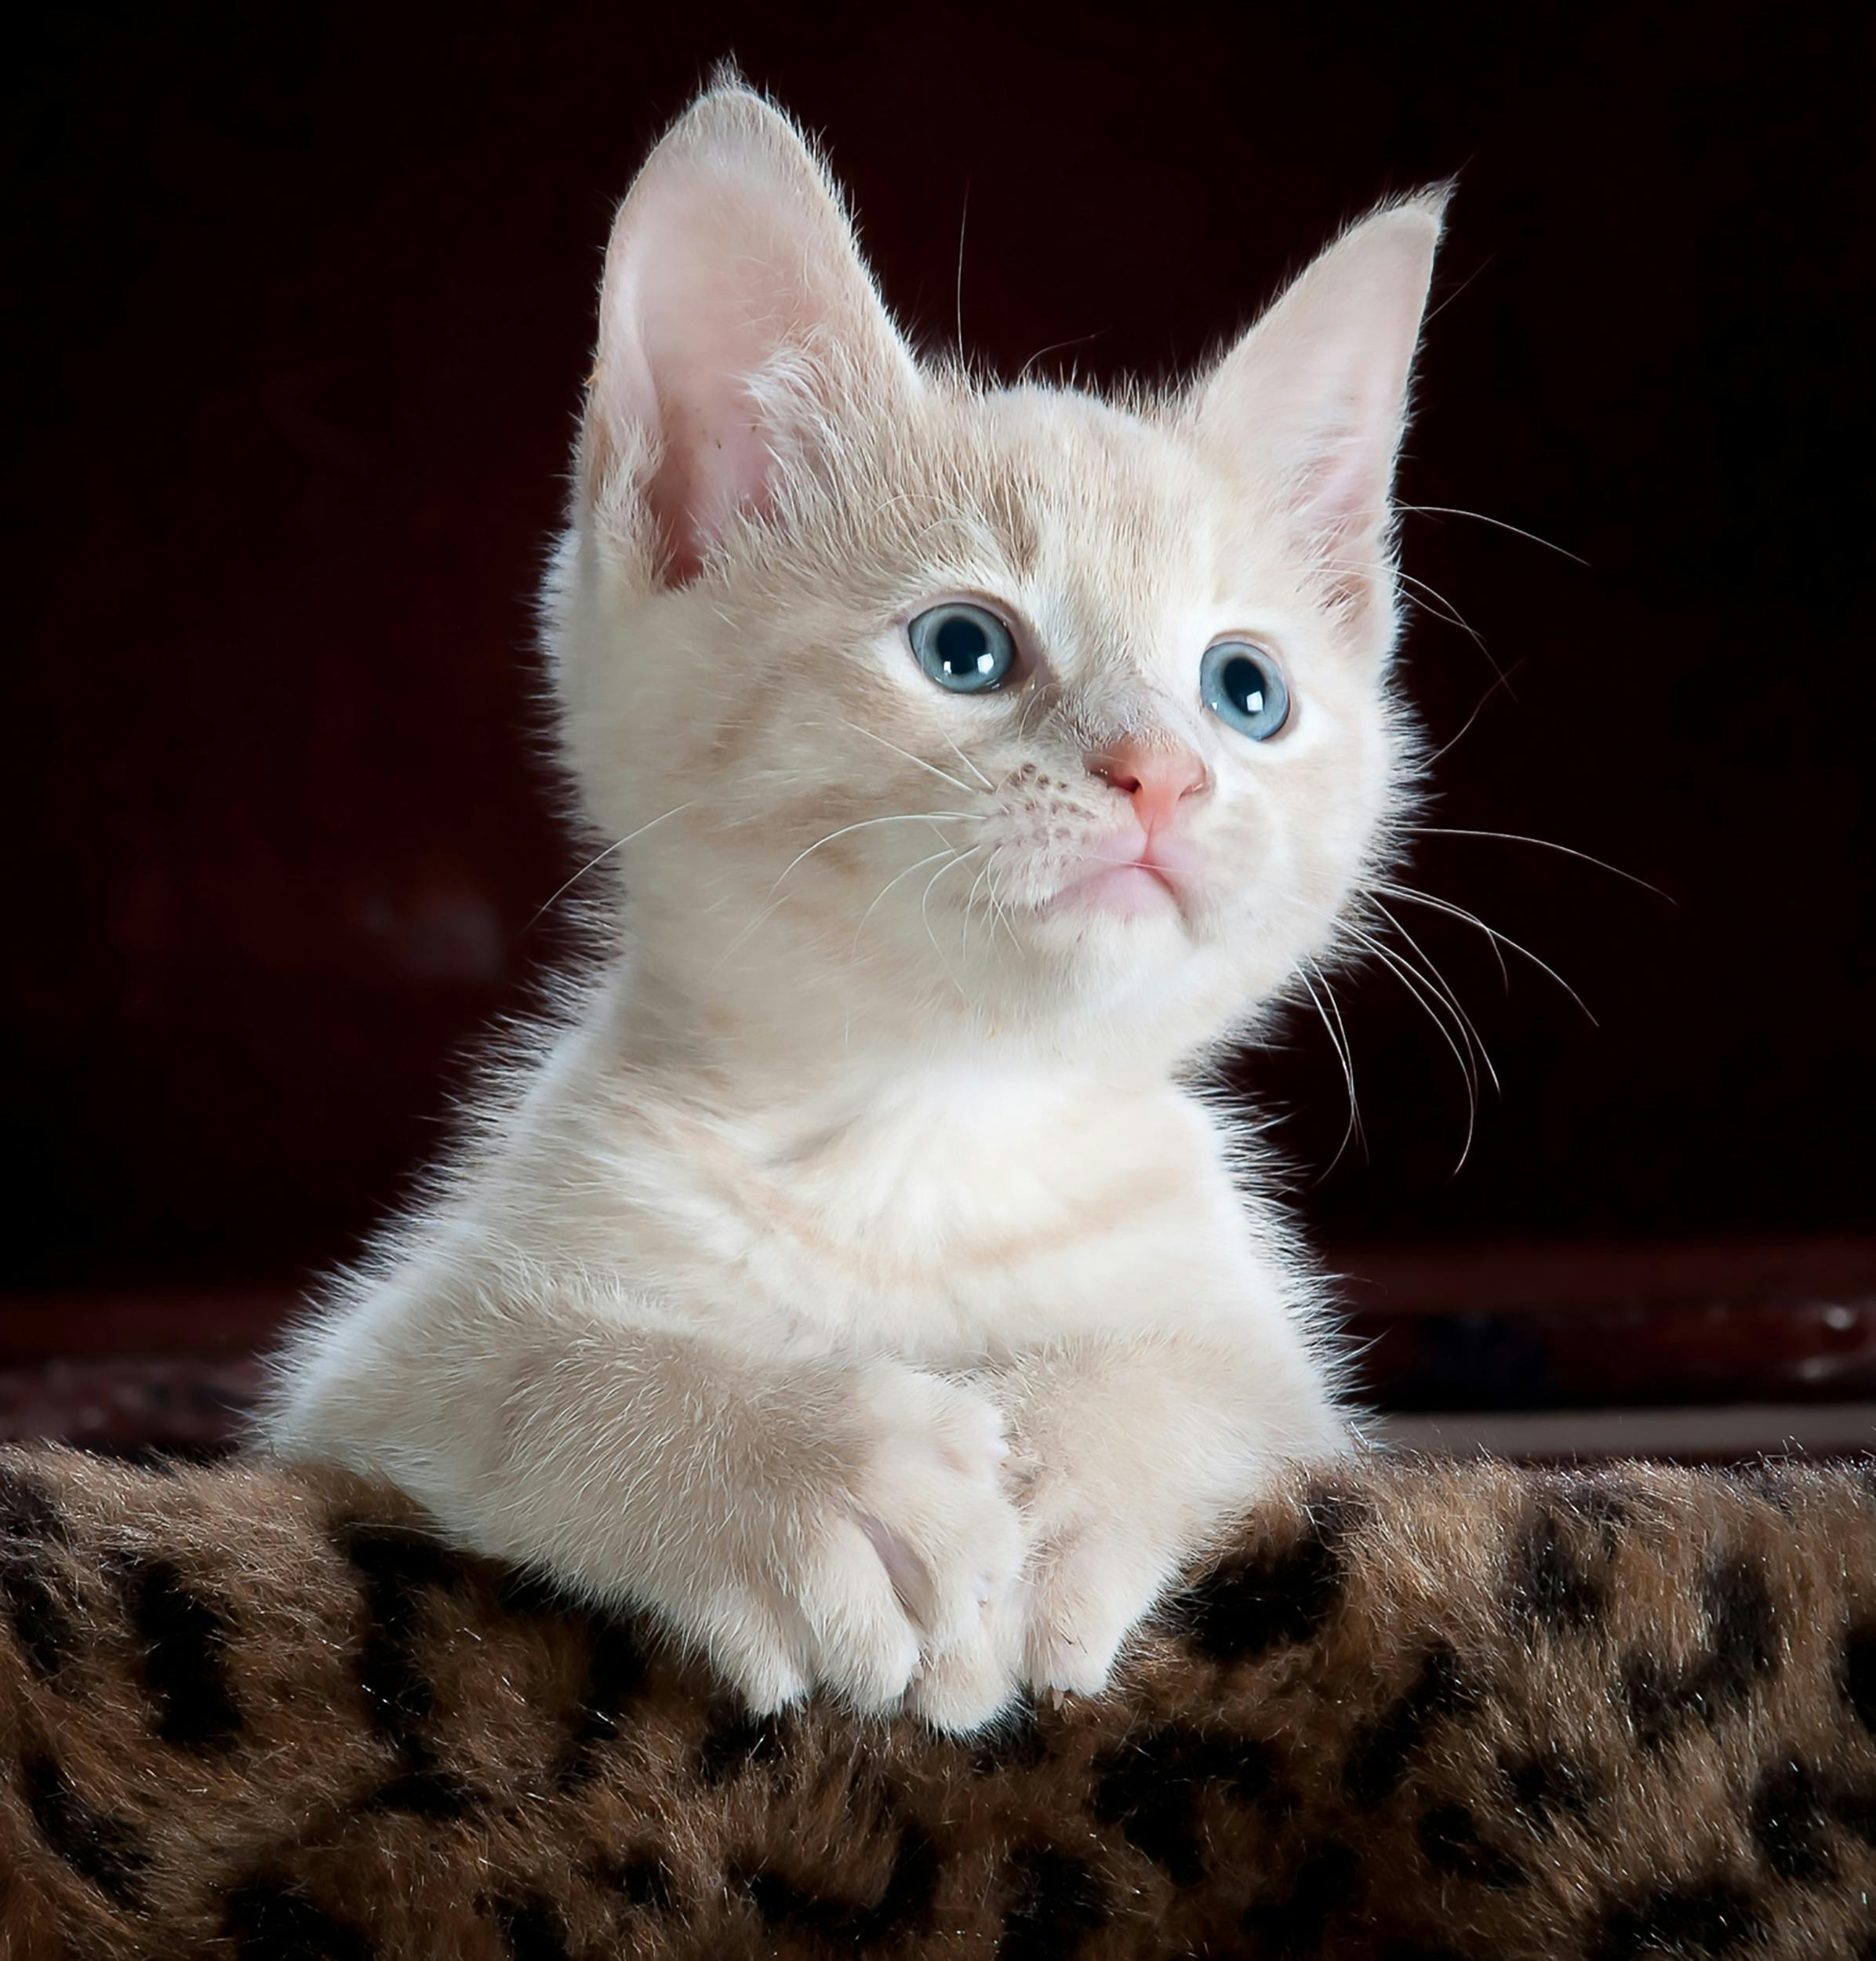

In [2]:
img = Image.open("cat_image.jpg")
img

In [3]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig

In [4]:
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

In [5]:
vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from torchvision import transforms

In [9]:
def preprocess_image(image, image_size=224):
  preprocess = transforms.Compose([
      transforms.Resize((image_size, image_size)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )
  ])

  image_tensor = preprocess(image)

  # (3, 224, 224) --> unsqueeze --> (1, 3, 224, 224)

  image_tensor = image_tensor.unsqueeze(0)
  return image_tensor

In [10]:
image_tensor = preprocess_image(img)

embed_dim = 768
patch_size = 16
image_size = 224
num_patches = (image_size // patch_size) ** 2

with torch.no_grad():
  patch_embedding = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
  patches = patch_embedding(image_tensor)

patches.shape, num_patches

(torch.Size([1, 768, 14, 14]), 196)

In [11]:
position_embedding = nn.Embedding(num_patches, embed_dim)
position_ids = torch.arange(num_patches).expand((1, -1))

position_ids.shape

torch.Size([1, 196])

In [13]:
# after flatten (1, 768, 196)
embeddings = patches.flatten(start_dim=2, end_dim=-1)
# (1, 768, 196) --> (1, 196, 768)
embeddings = embeddings.transpose(1, 2)

embeddings = embeddings + position_embedding(position_ids)

embeddings.shape

torch.Size([1, 196, 768])